In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner
import segmentation_models_pytorch as smp

from pathlib import Path
import random

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
import torch
torch.cuda.set_device(0)

In [3]:
%matplotlib inline
import numpy as np



Function por stablishing the seed for reproducibility


In [4]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
path = Path("dataset/")
path_images = path/"Images"
path_labels = path/"Labels"

test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [6]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))



Aux function for splitting between training and testing


In [7]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

Loading the codes of the different classes. All the datasets have the same codes.

In [8]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

In [9]:
def msa(input, target):
    target = target.squeeze(1)
    mask = target != -1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def background(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def leaves(input, target):
    target = target.squeeze(1)
    mask = target != 1
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def wood(input, target):
    target = target.squeeze(1)
    mask = target != 2
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def pole(input, target):
    target = target.squeeze(1)
    mask = target != 3
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

def grape(input, target):
    target = target.squeeze(1)
    mask = target != 4
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

Early Stopping parameters

In [10]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=3

In [11]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [12]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [13]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 4
        mask[mask==255]=4
        mask[mask==150]=1
        mask[mask==76]=3
        mask[mask==74]=3
        mask[mask==29]=2
        mask[mask==25]=2
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [14]:
path_manual_img = path_images/'train'
path_manual_lbl = path_labels/'train'

dataset/Images/train/color_159.jpg


<AxesSubplot:>

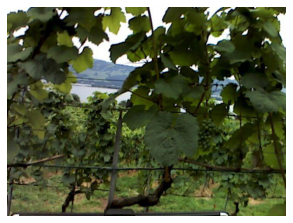

In [15]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [16]:
print(get_y_fn(img_f))

dataset/Labels/train/gt_159.png


<AxesSubplot:>

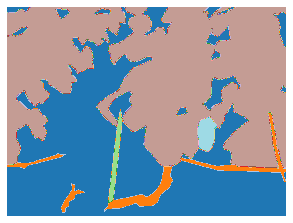

In [17]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [18]:
np.unique(np.array(mask))

array([  0,  29,  76, 150, 255], dtype=uint8)

In [19]:
bs = 4

In [20]:
codes

array(['Background', 'Leaves', 'Wood', 'Pole', 'Grape'], dtype='<U10')

In [21]:
def my_get_items(folders,path):
    return (get_image_files(path))

In [22]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
#manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
#dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [23]:
#x,mask=dls.one_batch()

# Deeplab

In [32]:
model = smp.Unet(
    encoder_name="efficientnet-b3",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
)

In [33]:
learn = Learner(dls,model,metrics=[background,leaves,pole,grape,wood,msa]).to_fp16()

Recorder

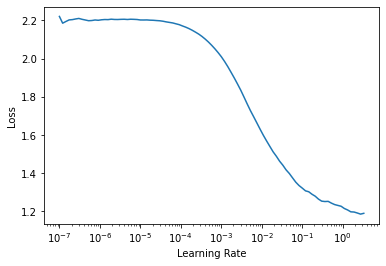

In [34]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,background,leaves,pole,grape,wood,msa,time
0,2.078482,1.794617,0.143313,0.284623,0.219080,0.218177,0.211590,0.217165,00:06
1,1.824842,1.438837,0.319307,0.470210,0.417473,0.415867,0.413552,0.412138,00:06
2,1.471152,0.933594,0.841770,0.634421,0.775332,0.773048,0.778699,0.764264,00:06
3,1.137778,0.624146,0.835890,0.732187,0.829182,0.826865,0.832775,0.817290,00:06
4,0.907129,0.697202,0.880430,0.599995,0.775290,0.773151,0.778202,0.764153,00:06
5,0.744842,0.741848,0.894513,0.522619,0.737261,0.734885,0.738922,0.726687,00:06
6,0.636225,0.632899,0.891027,0.587253,0.763581,0.752079,0.766369,0.752784,00:06


Better model found at epoch 0 with valid_loss value: 1.7946174144744873.


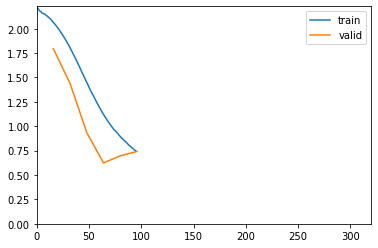

Better model found at epoch 1 with valid_loss value: 1.4388370513916016.
Better model found at epoch 2 with valid_loss value: 0.9335936903953552.
Better model found at epoch 3 with valid_loss value: 0.6241459250450134.
No improvement since epoch 3: early stopping


In [35]:
fname="deeplab-before-unfreeze"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [36]:
learn.load("deeplab-before-unfreeze")
learn.unfreeze()
#learn.lr_find() # find learning rate
#learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,background,leaves,pole,grape,wood,msa,time
0,0.502849,0.621577,0.849243,0.707983,0.822020,0.819724,0.825595,0.810232,00:06
1,0.497186,0.620553,0.850032,0.706394,0.821454,0.819169,0.825017,0.809673,00:06
2,0.494093,0.619033,0.850192,0.706582,0.821582,0.819300,0.825134,0.809797,00:06
3,0.497479,0.615436,0.849456,0.709303,0.822714,0.820434,0.826249,0.810912,00:06
4,0.501809,0.622138,0.852222,0.701882,0.819801,0.817523,0.823293,0.808039,00:06
5,0.502494,0.622139,0.852463,0.700332,0.819010,0.816737,0.822487,0.807258,00:06
6,0.500006,0.619981,0.851373,0.703708,0.820324,0.818048,0.823759,0.808551,00:06


Better model found at epoch 0 with valid_loss value: 0.6215766072273254.


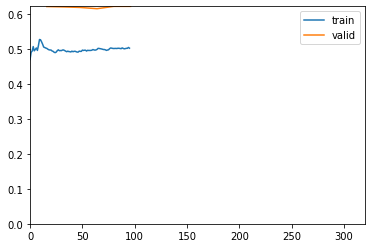

Better model found at epoch 1 with valid_loss value: 0.6205530166625977.
Better model found at epoch 2 with valid_loss value: 0.6190332174301147.
Better model found at epoch 3 with valid_loss value: 0.6154360175132751.
No improvement since epoch 3: early stopping


In [37]:
fname="unet-Efficient"


callbacksFitAfterUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(20, slice(1e-7,1e-7),cbs=callbacksFitAfterUnfreeze)

In [38]:
learn.validate()

(#7) [0.6154360175132751,0.8494564890861511,0.7093032598495483,0.8227136731147766,0.8204344511032104,0.826248824596405,0.8109119534492493]

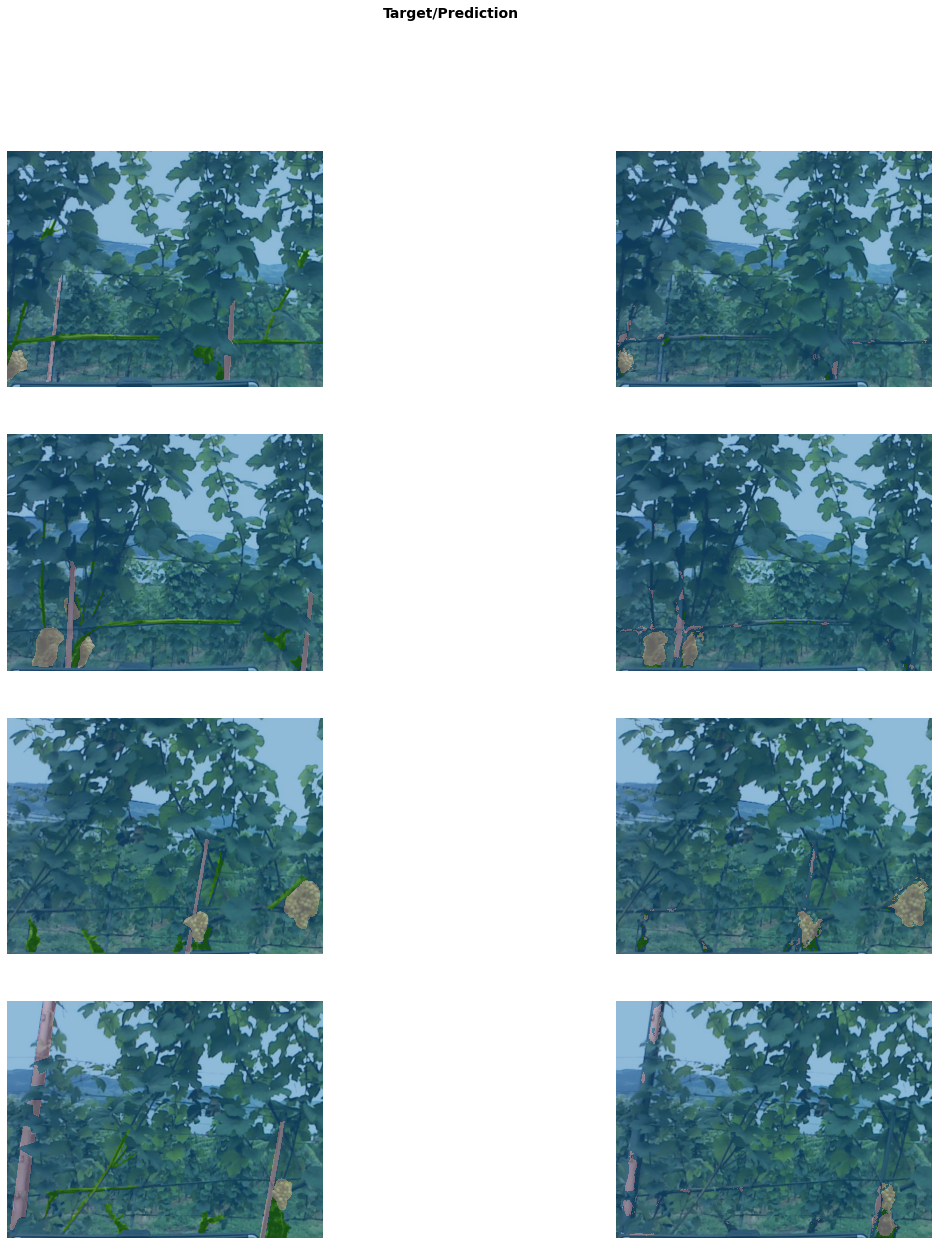

In [31]:
learn.show_results(figsize=(20,20))

In [31]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("deeplab.pth")

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# HRNet

model = torch.jit.load("deeplab.pth")
model = model.cpu()
model.eval()


RecursiveScriptModule(
  original_name=DeepLabV3Plus
  (backbone): RecursiveScriptModule(
    original_name=ResNetV1
    (conv1): RecursiveScriptModule(original_name=Conv2d)
    (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
    (relu): RecursiveScriptModule(original_name=ReLU)
    (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
    (layer1): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=BottleneckV1b
        (conv1): RecursiveScriptModule(original_name=Conv2d)
        (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv2): RecursiveScriptModule(original_name=Conv2d)
        (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        (conv3): RecursiveScriptModule(original_name=Conv2d)
        (bn3): RecursiveScriptModule(original_name=BatchNorm2d)
        (relu): RecursiveScriptModule(original_name=ReLU)
        (downsample): RecursiveScriptModule(
          original_name=Sequential

In [33]:
import torchvision.transforms as transforms
def transform_image(image):
    my_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image_aux = image
    return my_transforms(image_aux).unsqueeze(0).to(device)

In [53]:
image = Image.open('dataset/Images/test/color_154.jpg')

In [54]:
image = transforms.Resize((480,640))(image)
tensor = transform_image(image=image)

In [1]:
model.to(device)
with torch.no_grad():
    outputs = model(tensor)

outputs = torch.argmax(outputs,1)

NameError: name 'model' is not defined

In [56]:
mask = np.array(outputs.cpu())

In [57]:
mask[mask==4]=255
mask[mask==1]=150
mask[mask==3]=76
mask[mask==2]=29

In [58]:
mask=np.reshape(mask,(480,640))

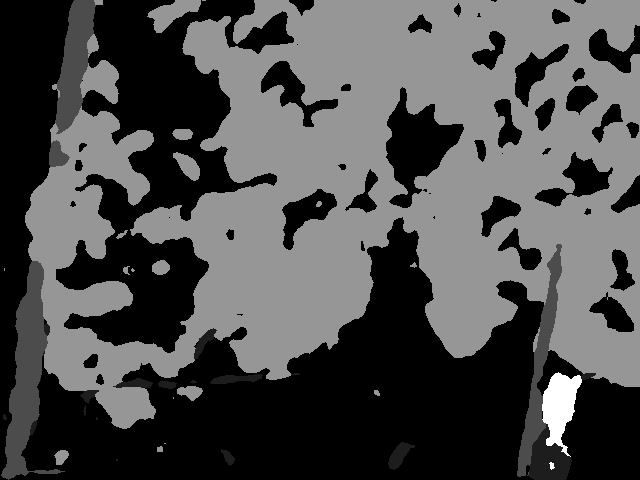

In [59]:
maskShow = Image.fromarray(mask.astype('uint8'))
maskShow

In [60]:
maskrgb = maskShow.convert('RGB')
maskrgb = np.array(maskrgb)
maskrgb[(maskrgb==[150,150,150]).all(axis=2)]=[0,255,0]
maskrgb[(maskrgb==[76,76,76]).all(axis=2)]=[255,0,0]
maskrgb[(maskrgb==[29,29,29]).all(axis=2)]=[0,0,255]

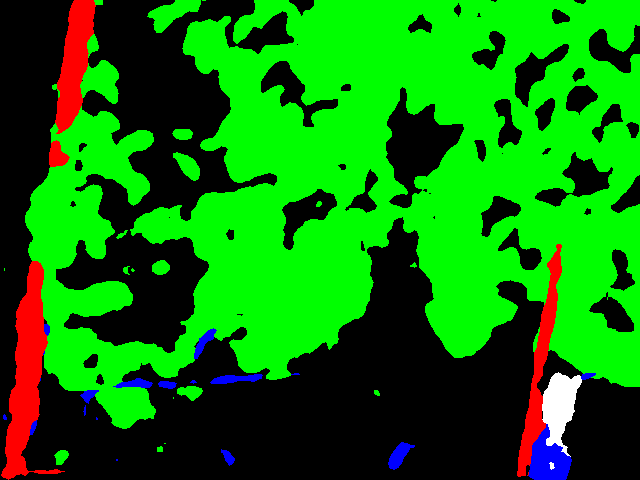

In [61]:
maskRGBShow = Image.fromarray(maskrgb.astype('uint8'))
maskRGBShow

In [43]:
maskRGBShow.save('deeplab_pred_155.jpg')